In [4]:
import pandas as pd
import os
import json
val_annotation_data = json.load(open(os.path.join('..', 'datasets', 'Annotations', 'v2_mscoco_val2014_annotations.json')))
val_annotation = pd.DataFrame(val_annotation_data["annotations"])
val_question_data = json.load(open(os.path.join('..', 'datasets', 'Questions', 'v2_OpenEnded_mscoco_val2014_questions.json')))
val_question = pd.DataFrame(val_question_data["questions"])


70


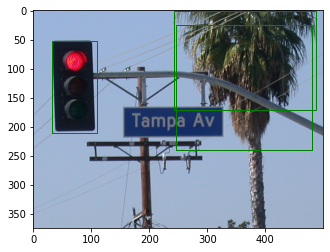

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.transforms as transforms
from matplotlib.patches import Rectangle
from PIL import Image
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



model = {
    # "50" :fasterrcnn_resnet50_fpn(prevaled=True).eval().to(device),
    # "60" :fasterrcnn_resnet50_fpn(prevaled=True).eval().to(device),
    "70" :fasterrcnn_resnet50_fpn(pretrained=True).eval().to(device),
}
# model["60"].roi_heads.nms_thresh = 0.6
model["70"].roi_heads.nms_thresh = 0.7
check = dict()
who = 150108
for idx in range(who, who+1000):
    idx_answers = pd.DataFrame(val_annotation.loc[idx, 'answers'])
    quest = val_annotation.loc[idx, 'question_id']
    question = val_question[val_question['question_id']==quest]['question'][idx]
    image_id = val_question[val_question['question_id']==quest]['image_id'][idx]
    if len(question) < 70:
        continue
    if image_id in check:
        continue
    check[image_id]=123

    normalize: transforms.Normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )

    image_rgb = Image.open(os.path.join('..','datasets','Images','val2014', f'COCO_val2014_{image_id:012}.jpg')).convert("RGB")
    image_Tensors = np.load(os.path.join('..','datasets','Image_Tensors','val2014', f'COCO_val2014_{image_id:012}.npy'))
    

    transform_without_normalize = transforms.Compose([
        transforms.ToTensor(),
        #normalize,
    ])
    image_dict = {
        "without normalize": transform_without_normalize(image_rgb).unsqueeze(0).to(device)
    }
    for x in image_dict:
        for y in model:
            print(y)
            image = image_dict[x]
            result = model[y](image)
            fig,ax = plt.subplots(1)

            ax.imshow(image_rgb)
            for xx, obj in enumerate(result):
                # obj's scores is descending
                boxes = obj["boxes"]
                scores = obj["scores"]
                scth=0.2
                for bi, (box, score) in enumerate(zip(boxes, scores)):
                    x1, y1, x2, y2 = int(box[0].item()), int(box[1].item()), int(box[2].item()), int(box[3].item())
                    box_plot = Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='green' if bi < 5 else 'red', linewidth=1)
                    ax.add_patch(box_plot)
            plt.show()
    break
